# **CLUSTERING**



# **Imports**  
Este código importa las bibliotecas necesarias para realizar análisis de datos, visualización, preprocesamiento y clustering en Python.  

### **Importación de bibliotecas**  

- **`pandas`**: Biblioteca para la manipulación y análisis de datos estructurados en forma de tablas (DataFrames).  
- **`numpy`**: Biblioteca para cálculos numéricos y manipulación de arreglos multidimensionales.  
- **`matplotlib.pyplot`**: Herramienta para crear visualizaciones gráficas (gráficos de líneas, barras, dispersión, etc.).  
- **`seaborn`**: Biblioteca basada en `matplotlib` que facilita la creación de visualizaciones estadísticas avanzadas.  
- **`warnings.filterwarnings('ignore')`**: Suprime las advertencias para evitar distracciones durante la ejecución del código.  

### **Preprocesamiento de datos**  

- **`MinMaxScaler`**: Escala las características en un rango específico (por defecto, entre 0 y 1), útil para algoritmos sensibles a la escala de los datos.  
- **`Pipeline`**: Permite encadenar múltiples pasos de preprocesamiento y modelado en una secuencia estructurada.  

### **Algoritmos de clustering**  

Se importan varios algoritmos de clustering para agrupar datos según patrones similares:  

- **`KMeans`**: Algoritmo basado en centroides que particiona los datos en K grupos.  
- **`DBSCAN`**: Algoritmo basado en densidad, útil para detectar clusters de formas arbitrarias y manejar ruido.  
- **`AgglomerativeClustering`**: Algoritmo jerárquico que agrupa los datos mediante un enfoque de fusión ascendente.  
- **`MeanShift`**: Algoritmo basado en estimación de densidad que encuentra clusters sin necesidad de especificar el número de grupos.  
- **`GaussianMixture`**: Modelo probabilístico basado en la combinación de múltiples distribuciones gaussianas para identificar clusters.  

### **Evaluación y optimización de modelos**  

- **`GridSearchCV`**: Herramienta para realizar la búsqueda de hiperparámetros óptimos mediante validación cruzada.  
- **`silhouette_score`**: Métrica de evaluación que mide la calidad del agrupamiento en términos de cohesión y separación de clusters.  
- **`make_scorer`**: Convierte una métrica en un formato compatible con `GridSearchCV` para optimización de modelos.  
- **`v_measure_score`**: Métrica utilizada para evaluar la calidad de los clusters generados en comparación con etiquetas verdaderas. Es una medida basada en la homogeneidad y la completitud, proporcionando un equilibrio entre ambas. Un valor más alto indica una mejor correspondencia entre los clusters y las clases reales.  

### **Reducción de dimensionalidad**  

- **`PCA (Principal Component Analysis)`**: Técnica de reducción de dimensionalidad que transforma los datos en un conjunto de componentes principales ortogonales, preservando la mayor cantidad de varianza posible. Se utiliza para visualizar datos en espacios de menor dimensión y para reducir la complejidad del modelo al eliminar características redundantes.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, make_scorer, v_measure_score
from sklearn.decomposition import PCA

# **Preproceso del Dataset**
El código realiza la carga y preprocesamiento de datos de calidad del aire desde un archivo CSV.

### **Carga de datos**  
Se carga el archivo de datos utilizando la librería `pandas`, especificando el delimitador adecuado para su correcta interpretación.

### **Conversión de fechas y creación de variables derivadas**  
Se convierten las columnas de fecha a un formato de fecha y hora adecuado. Luego, se extraen componentes como el día, mes y año, creando nuevas columnas con estos valores.  

### **Conversión de la columna de hora**  
Se transforma la columna de tiempo en un formato de hora reconocible para facilitar su manipulación.

### **Mapeo de días de la semana**  
Se genera una nueva columna que almacena el nombre del día de la semana correspondiente a cada fecha y se convierte a valores numéricos utilizando un diccionario de mapeo.
Esta columna se crea para luego poder entrenar los modelos. Los números van del 0 al 6.

### **Categorización por partes del día columna `PeriodoDia`**
Se define una función que categoriza las horas en tres períodos del día:  
- **Mañana:** 6 AM - 12 PM  
- **Tarde:** 12 PM - 6 PM  
- **Noche:** 6 PM - 6 AM  

El rango es de 0 a 2 siendo la mañana 0, la tarde 1 y la noche 2.
Esta función se aplica a la columna de tiempo.

Esta columna se crea para luego poder entrenar los modelos.

### **Clasificación de estaciones del año**  
Se define una función que clasifica los meses en las cuatro estaciones del año:  
- **Primavera:** Marzo (3), Abril (4), Mayo (5) → 0  
- **Verano:** Junio (6), Julio (7), Agosto (8) → 1  
- **Otoño:** Septiembre (9), Octubre (10), Noviembre (11) → 2  
- **Invierno:** Diciembre (12), Enero (1), Febrero (2) → 3  

Se aplica esta función a la columna de meses para crear la nueva columna `Estacion`.

### **Reemplazo de caracteres y conversión de tipos de datos**  
Se reemplazan las comas por puntos en ciertas columnas para permitir la conversión a formato numérico de punto flotante.

### **Conversión de valores numéricos a enteros**  
Se verifica si las columnas numéricas contienen solo valores enteros y, en ese caso, se convierten al tipo de dato entero compatible con valores nulos.

### **Eliminación de columnas innecesarias**  
Se eliminan columnas irrelevantes o vacías que no aportan información útil para el análisis.

Borramos `Unnamed: 15`, `Unnamed: 16`, `Time`.

Las 2 primeras columnas se borrar porque estan vacias y la de `Time` la borramos porque la hora ya la tenemos con la columna `PeriodoDia`.

### **Limpieza de filas con valores faltantes**  
Se eliminan las filas donde todos los valores son nulos para mantener la calidad del dataset.

### **Visualización de información**  
Finalmente, se muestra la estructura del DataFrame, incluyendo los tipos de datos de cada columna y los primeros registros del conjunto de datos para su inspección.

In [11]:
# Cargar los datos
df = pd.read_csv('data/AirQuality.csv', delimiter=';')

# Convertir las fechas y horas
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')
# Crear las variables derivadas de 'Date'
df['Dia'] = df['Date'].dt.day
df['Mes'] = df['Date'].dt.month
df['Anio'] = df['Date'].dt.year

df['Time'] = pd.to_datetime(df['Time'], format='%H.%M.%S', errors='coerce').dt.time

# Mapear días de la semana a números
df['DiaSemana'] = df['Date'].dt.day_name()
dias_semana_map = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2,
    'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6
}
df['DiaSemana'] = df['DiaSemana'].map(dias_semana_map)

# Categorizar por partes del día
def time_to_period(hour):
    if 6 <= hour < 12:
        return 0 #Mañana
    elif 12 <= hour < 18:
        return 1 #Tarde
    else:
        return 2 #Noche

df['PeriodoDia'] = df['Time'].apply(lambda t: time_to_period(t.hour) if pd.notnull(t) else None)

# Función para clasificar las estaciones
def mes_a_estacion(mes):
    if mes in [3, 4, 5]:
        return 0 #Primavera
    elif mes in [6, 7, 8]:
        return 1 #Verano
    elif mes in [9, 10, 11]:
        return 2 #Otoño
    else:
        return 3 #Invierno

# Aplicar la función para crear la columna de estación
df['Estacion'] = df['Mes'].apply(mes_a_estacion)


# Reemplazar comas por puntos y convertir columnas a float
columns_to_convert = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']
for col in columns_to_convert:
    df[col] = df[col].str.replace(',', '.', regex=False).astype(float)

# Convertir todas las columnas numéricas a enteros si no tienen decimales
for col in df.select_dtypes(include=['float', 'int']).columns:
    if df[col].dropna().mod(1).eq(0).all():  # Verifica si todos los valores son enteros
        df[col] = df[col].astype('Int64')  # Convierte a entero compatible con NaN

# Configuración para que no muestre decimales en pandas
pd.set_option('display.float_format', '{:.0f}'.format)


# Eliminar columnas innecesarias
df = df.drop(columns=['Unnamed: 15', 'Unnamed: 16', 'Time'], errors='ignore')
# Eliminar filas donde todos los valores, incluyendo el índice, sean NaN
df = df.dropna()

# Mostrar información y primeros registros
print("Tipos de datos:")
print(df.dtypes)
print("\nPrimeros registros:")
print(df.head())



Tipos de datos:
Date             datetime64[ns]
CO(GT)                  float64
PT08.S1(CO)               Int64
NMHC(GT)                  Int64
C6H6(GT)                float64
PT08.S2(NMHC)             Int64
NOx(GT)                   Int64
PT08.S3(NOx)              Int64
NO2(GT)                   Int64
PT08.S4(NO2)              Int64
PT08.S5(O3)               Int64
T                       float64
RH                      float64
AH                      float64
Dia                       Int64
Mes                       Int64
Anio                      Int64
DiaSemana                 Int64
PeriodoDia                Int64
Estacion                  Int64
dtype: object

Primeros registros:
        Date  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0 2004-03-10       3         1360       150        12           1046      166   
1 2004-03-10       2         1292       112         9            955      103   
2 2004-03-10       2         1402        88         9            9

# **Proceso de Limpieza y Preparación de Datos: Manejo de Valores Faltantes y Erróneos**

### **Lista de columnas a imputar**:  
   Se define una lista de columnas que contienen datos faltantes, representados como valores `NaN` o erróneos. Estas columnas son seleccionadas para ser procesadas en el análisis de imputación de datos.

### **Convertir columnas a tipo float**:  
   Se convierten las columnas seleccionadas a tipo `float` para garantizar que los datos sean tratados correctamente durante el proceso de imputación, evitando posibles errores por incompatibilidad de tipos de datos.

### **Reemplazar valores -200 con NaN**:  
   Se identifican los valores `-200` en las columnas seleccionadas, los cuales se consideran como valores erróneos o inválidos, y se reemplazan por `NaN` para que puedan ser tratados adecuadamente en el análisis.

### **Contar valores nulos antes de la eliminación**:  
   Se cuenta el número de valores nulos (representados como `NaN`) en las columnas seleccionadas antes de realizar cualquier operación de limpieza o imputación, proporcionando una visión de la cantidad de datos faltantes.

### **Calcular porcentaje de valores nulos**:  
   Se calcula el porcentaje de valores nulos en cada columna, lo que ayuda a entender la magnitud del problema de datos faltantes. Este porcentaje es clave para tomar decisiones sobre la imputación o eliminación de datos.

### **Eliminar la columna 'NMHC(GT)'**:  
   Se elimina la columna `'NMHC(GT)'` del DataFrame, ya que contiene un 90% de valores faltantes, lo que la hace inapropiada para el análisis. Al eliminarla, se mejora la calidad del conjunto de datos.

### **Actualizar la lista de columnas después de eliminar 'NMHC(GT)'**:  
   Se actualiza la lista de columnas a imputar (`imputar_nan`) para reflejar la eliminación de la columna `'NMHC(GT)'`, asegurando que el análisis se realice solo sobre las columnas relevantes.

### **Eliminar filas donde haya valores NaN en las columnas seleccionadas**:  
   Se eliminan las filas que contienen valores `NaN` en las columnas seleccionadas, ya que los datos faltantes en estas filas comprometen la calidad del análisis y la capacidad del modelo para realizar predicciones precisas.

### **Conclusión**
Durante el análisis del conjunto de datos, se identificó la presencia de valores erróneos registrados como -200, los cuales se interpretan como datos incorrectos. Para abordar este problema, dichos valores fueron reemplazados por `NaN` con el fin de evaluar la cantidad de datos faltantes en cada columna.  

Se detectó que la columna 'NMHC(GT)' presentaba un 90% de valores faltantes, por lo que se decidió eliminarla del conjunto de datos, ya que su alto nivel de ausencia compromete su utilidad para el análisis. En cuanto a las demás columnas, aunque presentan un porcentaje menor de valores faltantes, se observó que las filas con datos faltantes afectan múltiples variables simultáneamente. Debido a esto, se optó por eliminar las filas completas en lugar de intentar imputar valores, ya que la falta de información en varias variables dificulta la capacidad del modelo para realizar predicciones precisas.  

Se realizaron pruebas de imputación utilizando tanto la media como la mediana con el objetivo de evaluar cuál de estos métodos sería más adecuado. A través del análisis visual y exploratorio de los datos, se determinó que la mediana era la opción más óptima. Se observó que los datos presentaban una distribución asimétrica, lo que indicaba la presencia de valores atípicos que podrían distorsionar la media. La mediana, al ser menos sensible a estos valores extremos, ofreció una representación más robusta y precisa de la tendencia central. Sin embargo, debido a la presencia de valores faltantes en múltiples columnas de la misma fila, se concluyó que la mejor estrategia era eliminar dichas filas en lugar de imputarlas, garantizando así la calidad del conjunto de datos para su posterior análisis.


In [12]:
# Lista de columnas a imputar.
imputar_nan = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NMHC(GT)', 'NO2(GT)', 
               'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)',
               'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

# Convertir columnas a tipo float para evitar problemas de tipo de dato
df[imputar_nan] = df[imputar_nan].astype(float)

# Reemplazar valores -200 con NaN en las columnas seleccionadas
df[imputar_nan] = df[imputar_nan].replace(-200, np.nan)

# Contar valores nulos antes de la eliminación
valores_nulos = df[imputar_nan].isna().sum()

# Calcular porcentaje de valores nulos
porcentaje_nulos = (valores_nulos / len(df)) * 100

# Mostrar valores nulos antes de la eliminación
print("Valores faltantes por columna (antes de eliminación):")
print(valores_nulos)

print("\nPorcentaje de valores faltantes por columna:")
print(porcentaje_nulos.round(2).astype(str) + '%')

# Eliminar la columna 'NMHC(GT)' ya que tiene un 90% de valores faltantes
df = df.drop(columns=['NMHC(GT)'], errors='ignore')

# Actualizar la lista de columnas después de eliminar 'NMHC(GT)'
imputar_nan.remove('NMHC(GT)')

# Eliminar filas donde haya valores NaN en las columnas seleccionadas
df = df.dropna(subset=imputar_nan)

# Mostrar valores después de eliminar filas con valores nulos
print("\nValores faltantes por columna (después de eliminación):")
print(df.isna().sum())

# Mostrar las primeras filas del DataFrame después de limpieza
print("\nDataFrame después de eliminación de valores nulos:")
print(df.head())


Valores faltantes por columna (antes de eliminación):
CO(GT)           1683
C6H6(GT)          366
NOx(GT)          1639
NMHC(GT)         8443
NO2(GT)          1642
PT08.S1(CO)       366
PT08.S2(NMHC)     366
PT08.S3(NOx)      366
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64

Porcentaje de valores faltantes por columna:
CO(GT)           17.99%
C6H6(GT)          3.91%
NOx(GT)          17.52%
NMHC(GT)         90.23%
NO2(GT)          17.55%
PT08.S1(CO)       3.91%
PT08.S2(NMHC)     3.91%
PT08.S3(NOx)      3.91%
PT08.S4(NO2)      3.91%
PT08.S5(O3)       3.91%
T                 3.91%
RH                3.91%
AH                3.91%
dtype: object

Valores faltantes por columna (después de eliminación):
Date             0
CO(GT)           0
PT08.S1(CO)      0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH       

# **Historia 1: Análisis de Concentración Promedio de Gases por Día de la Semana y Periodo del Día**
## **Hipótesis:**  
La concentración de contaminantes (CO, C6H6, NOx y NO2) es mayor durante las primeras horas del día (mañana) en comparación con los periodos posteriores (tarde y noche), especialmente en los días laborables (lunes a viernes). 

## **Conclusión:**  
Los datos observados confirman que los días laborables presentan mayores concentraciones de contaminantes en comparación con los fines de semana, debido a la mayor actividad humana. Se evidencia que las concentraciones de CO, C6H6, NOx y NO2 son más altas en la mañana, disminuyendo a lo largo del día, lo que indica que el tráfico y las actividades industriales matutinas son los principales contribuyentes. Los lunes y viernes presentan los niveles más elevados, mientras que los domingos muestran las concentraciones más bajas, reflejando una reducción en la actividad económica y vehicular.

---

Este código tiene como objetivo analizar la concentración promedio de contaminantes atmosféricos en función del día de la semana y el periodo del día, visualizando los resultados mediante gráficos de barras para facilitar la comparación.

### **Explicación del Proceso**

1. **Selección de columnas relevantes:**  
   - Se definen dos listas de columnas:  
     - `gases_media_semana`: Incluye los contaminantes de interés junto con las variables `PeriodoDia` y `DiaSemana`, que permiten analizar la distribución temporal.  
     - `gases`: Contiene únicamente los nombres de los gases contaminantes que serán evaluados:  
       - `CO(GT)`: Monóxido de carbono  
       - `C6H6(GT)`: Benceno  
       - `NOx(GT)`: Óxidos de nitrógeno  
       - `NO2(GT)`: Dióxido de nitrógeno  

2. **Agrupación y cálculo de la media:**  
   - Se agrupan los datos por las columnas `DiaSemana` y `PeriodoDia` utilizando la función `groupby()`.  
   - Se calcula la media de cada contaminante en función de estas categorías.  
   - Los valores resultantes se redondean a dos decimales para mejorar la legibilidad de los resultados.

3. **Creación de gráficos de barras:**  
   - Se genera una figura con subgráficos (uno por contaminante), utilizando `plt.subplots()`.  
   - Para cada contaminante, los datos se reorganizan mediante `pivot()`, donde los días de la semana son las filas y los periodos del día son las columnas, permitiendo la comparación entre periodos.  
   - Se utiliza `plot(kind='bar')` para crear gráficos de barras apiladas.

4. **Personalización del gráfico:**  
   - Se añaden títulos personalizados para cada gráfico con el nombre del contaminante correspondiente.  
   - Se etiquetan los ejes:  
     - El eje x representa los días de la semana.  
     - El eje y muestra la concentración promedio de los gases.  
   - Se añade una leyenda indicando los periodos del día analizados.

5. **Ajuste del diseño y visualización:**  
   - La función `plt.tight_layout()` se emplea para optimizar la disposición de los gráficos y evitar superposiciones.  
   - Finalmente, se muestra la visualización con `plt.show()`.

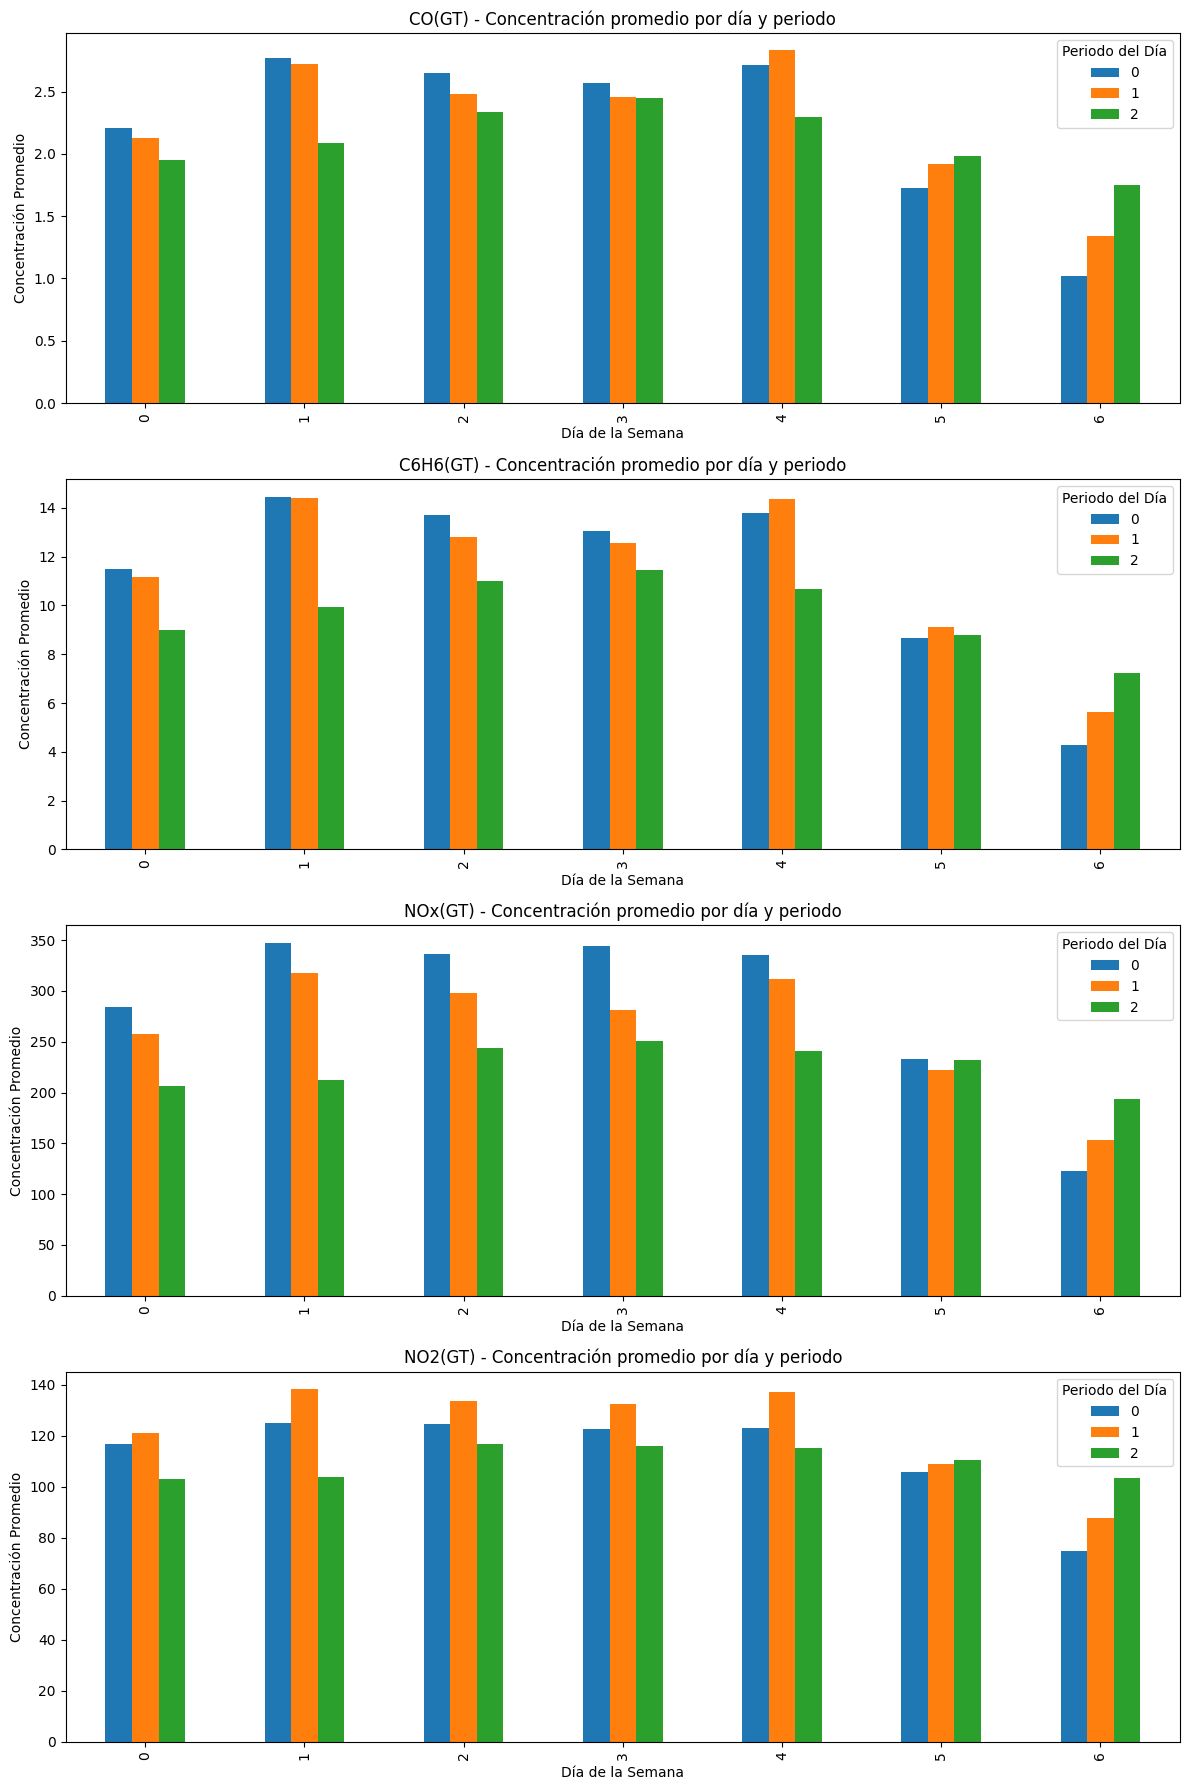

In [13]:
gases_media_semana = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'PeriodoDia', 'DiaSemana']
gases = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']

# Agrupar por día de la semana y periodo del día, y calcular la media de cada gas
df_grouped = df[gases_media_semana].groupby(['DiaSemana', 'PeriodoDia']).mean().reset_index().round(2)

# Crear una figura con subgráficos para cada gas
fig, axes = plt.subplots(len(gases), 1, figsize=(12, 18))

for i, gas in enumerate(gases):
    # Reorganizar los datos para graficar
    gas_data = df_grouped.pivot(index='DiaSemana', columns='PeriodoDia', values=gas)
    gas_data.plot(kind='bar', ax=axes[i], legend=True)
    
    axes[i].set_title(f'{gas} - Concentración promedio por día y periodo')
    axes[i].set_xlabel('Día de la Semana')
    axes[i].set_ylabel('Concentración Promedio')
    axes[i].legend(title='Periodo del Día')

# Ajustar el diseño de la figura para evitar superposiciones
plt.tight_layout()
plt.show()

# **Historia 2: ¿En invierno hay más contaminación que en verano?**
## **Hipótesis:**  
La concentración de los contaminantes CO, C6H6, NOx y NO2 es mayor en invierno que en verano, debido a factores estacionales como condiciones meteorológicas adversas y un mayor uso de calefacción.  

## **Conclusión:**  
Los datos analizados confirman la hipótesis de que la concentración de contaminantes como CO(GT), NOx(GT) y NO2(GT) es más alta en invierno debido al mayor uso de calefacción y a las condiciones de dispersión menos favorables. Sin embargo, la concentración de C6H6(GT) es mayor en verano, lo que sugiere que sus principales fuentes de emisión, como la actividad industrial y el tráfico, son más intensas en esta estación. Factores meteorológicos, como la inversión térmica en invierno y la fotodisociación en verano, desempeñan un papel clave en la variación estacional de los contaminantes.

---

El siguiente código tiene como objetivo comparar la concentración promedio de varios contaminantes atmosféricos entre las estaciones de verano e invierno mediante gráficos de barras.

### **Explicación del Proceso**

1. **Filtrado de datos:**  
   - Se seleccionan únicamente los registros correspondientes a las estaciones de verano (representada por el valor `1`) e invierno (representada por el valor `3`).  
   - Para ello, se utiliza la función `isin()` para filtrar los datos dentro del DataFrame.

2. **Selección de columnas:**  
   - Se identifican las columnas de interés correspondientes a los contaminantes:  
     - `CO(GT)`: Monóxido de carbono  
     - `C6H6(GT)`: Benceno  
     - `NOx(GT)`: Óxidos de nitrógeno  
     - `NO2(GT)`: Dióxido de nitrógeno  

3. **Agrupación de datos y cálculo de promedios:**  
   - Se agrupan los datos por la columna de estación (`Estacion`).  
   - Se calcula la concentración promedio de cada gas mediante la función `mean()` y se reinicia el índice para facilitar su manipulación posterior.

4. **Generación de gráficos de barras:**  
   - Se crean subgráficos, uno para cada gas, utilizando `plt.subplots()`.  
   - Se genera un gráfico de barras para cada contaminante, comparando las concentraciones entre verano e invierno.  
   - Se personalizan los gráficos con títulos, etiquetas de los ejes y una leyenda que indica el gas correspondiente.

5. **Personalización de la visualización:**  
   - Se asignan etiquetas descriptivas a las estaciones en el eje x, reemplazando los valores numéricos (`1` y `3`) por los nombres correspondientes (`Verano` e `Invierno`).  
   - Se ajusta la disposición de los gráficos para una mejor visualización mediante `plt.tight_layout()`.  
   - Finalmente, se muestra el gráfico con la función `plt.show()`.

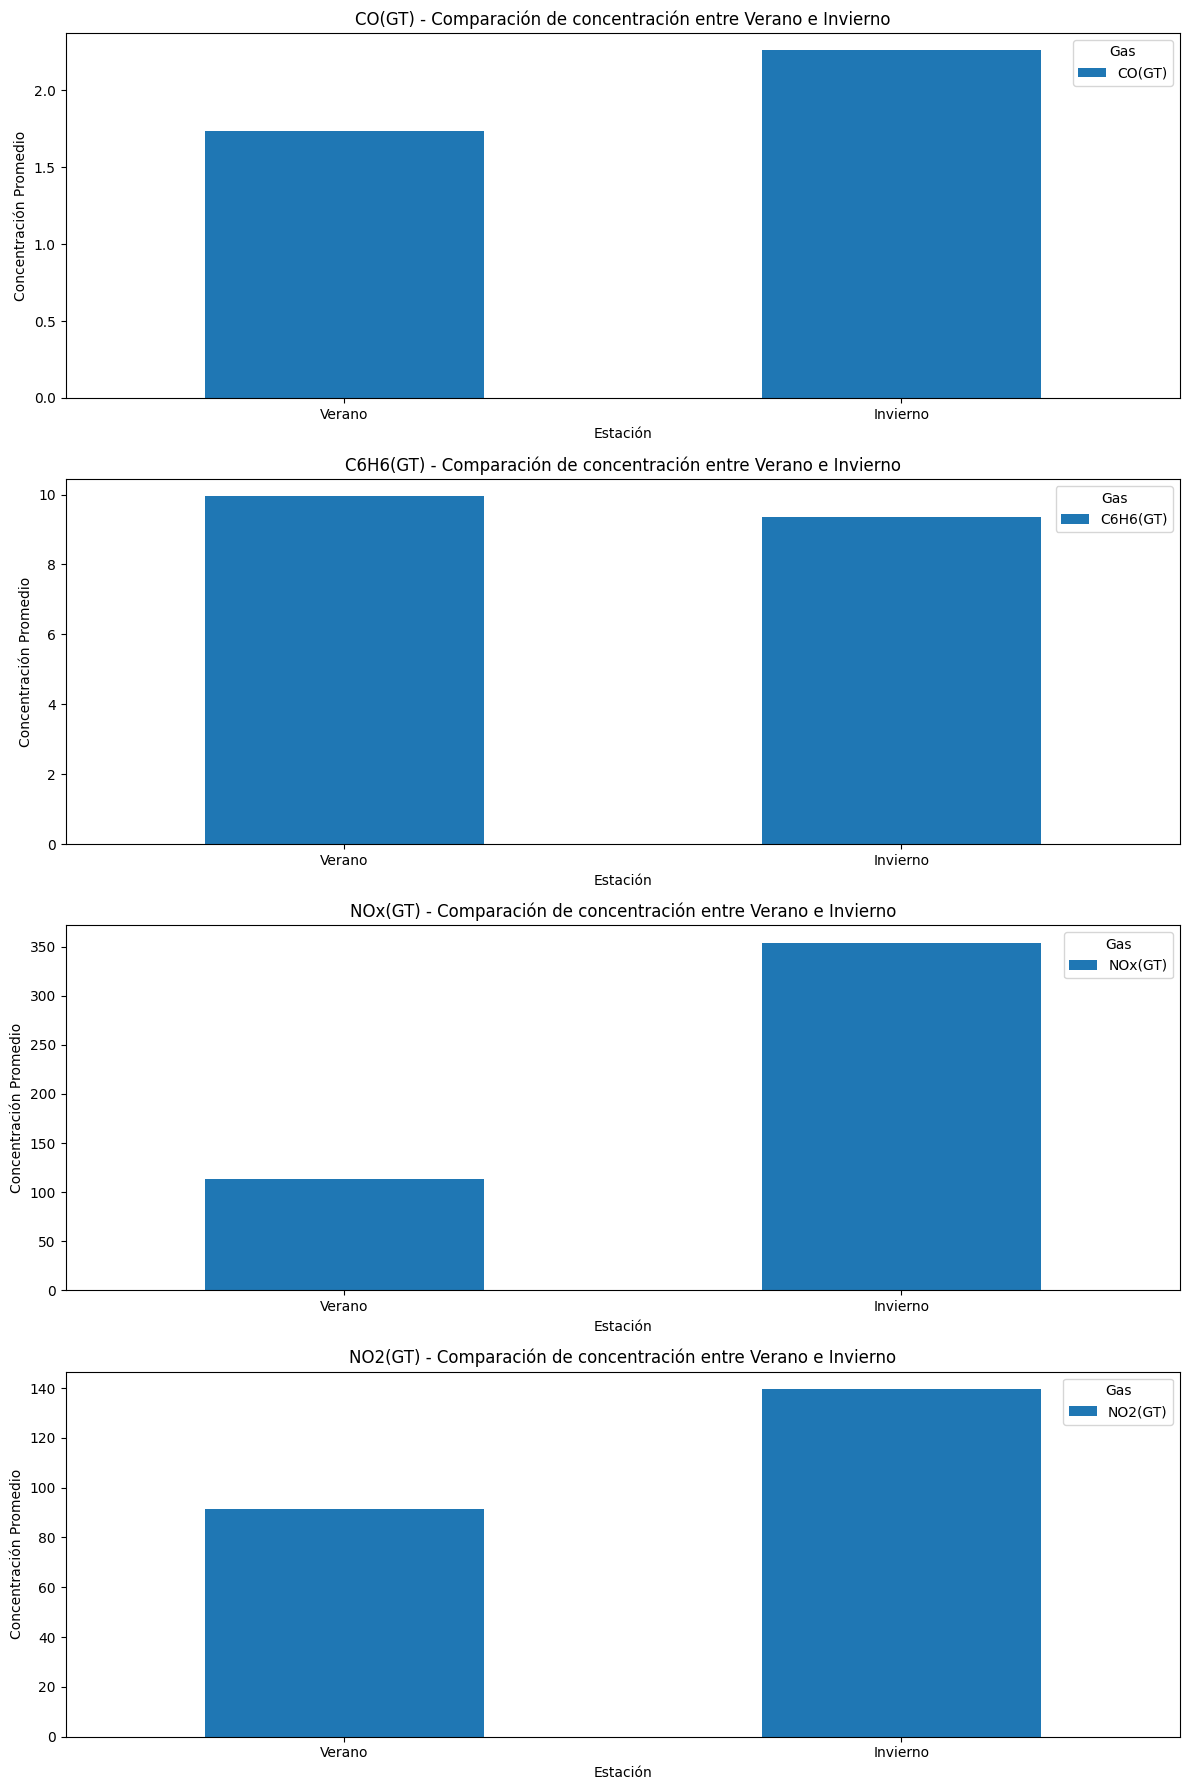

In [14]:
# Filtrar los datos para obtener solo Verano e Invierno
df_verano_invierno = df[df['Estacion'].isin([1, 3])]  # 1 = Verano, 3 = Invierno

# Seleccionar las columnas de gases
gases = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']

# Agrupar por estación y calcular la media de cada gas
df_verano_invierno_grouped = df_verano_invierno.groupby('Estacion')[gases].mean().reset_index()

# Crear un gráfico de barras para comparar Verano e Invierno
fig, axes = plt.subplots(len(gases), 1, figsize=(12, 18))

# Asignar nombres a las estaciones para la leyenda
estaciones_map = {1: 'Verano', 3: 'Invierno'}

for i, gas in enumerate(gases):
    df_verano_invierno_grouped.plot(kind='bar', x='Estacion', y=gas, ax=axes[i], legend=False)
    axes[i].set_title(f'{gas} - Comparación de concentración entre Verano e Invierno')
    axes[i].set_xlabel('Estación')
    axes[i].set_ylabel('Concentración Promedio')
    axes[i].set_xticklabels([estaciones_map[est] for est in df_verano_invierno_grouped['Estacion']], rotation=0)
    
    # Mostrar la leyenda
    axes[i].legend([gas], title='Gas')

# Ajustar el diseño del gráfico
plt.tight_layout()
plt.show()


# **Historia 3: Impacto de la Temperatura en la Concentración de Contaminantes Atmosféricos**
## **Hipótesis:**  
La concentración de contaminantes atmosféricos, como **NOx(GT)** y **NO2(GT)**, es mayor en temperaturas bajas debido a una menor dispersión atmosférica y un aumento en la generación de emisiones, mientras que en temperaturas más altas, la concentración disminuye por una mayor dispersión y condiciones meteorológicas favorables.

## **Conclusión:**  
El análisis de la concentración promedio de contaminantes por rango de temperatura confirma que los niveles de **NOx(GT)** y **NO2(GT)** son significativamente más altos en temperaturas bajas (**-2°C a 10°C**), lo que sugiere que las condiciones atmosféricas frías favorecen la acumulación de contaminantes. A medida que la temperatura aumenta, se observa una disminución progresiva de estas concentraciones, indicando que el calor facilita la dispersión de los contaminantes en el ambiente. Además, los niveles de **CO(GT)** y **C6H6(GT)** muestran variaciones menos pronunciadas, manteniéndose relativamente estables en todos los rangos de temperatura.

---

Este código tiene como objetivo analizar la relación entre la temperatura y la concentración promedio de contaminantes atmosféricos mediante la clasificación de temperaturas en distintos rangos y la generación de un gráfico de barras comparativo.

### **Explicación del Proceso**

1. **Clasificación de la temperatura en rangos:**  
   - Se definen intervalos de temperatura personalizados utilizando la lista `bins`, que segmenta las temperaturas en los siguientes rangos:  
     - `Bajo (-2°C a 10°C)`  
     - `Moderado (10°C a 20°C)`  
     - `Cálido (20°C a 30°C)`  
     - `Calor (30°C a 45°C)`  
   - Se crea una nueva columna denominada `Temp_Rango` en el DataFrame `df`, donde se asignan etiquetas descriptivas a cada rango de temperatura utilizando la función `pd.cut()`.

2. **Agrupación y cálculo de medias:**  
   - Se seleccionan las columnas de gases contaminantes de interés:  
     - `CO(GT)`: Monóxido de carbono  
     - `C6H6(GT)`: Benceno  
     - `NOx(GT)`: Óxidos de nitrógeno  
     - `NO2(GT)`: Dióxido de nitrógeno  
   - Se agrupan los datos por los rangos de temperatura definidos en la columna `Temp_Rango`, y se calcula el promedio de cada contaminante con la función `mean()`.

3. **Generación del gráfico de barras:**  
   - Se crea una figura con `plt.subplots()` para visualizar la comparación de las concentraciones de contaminantes por rango de temperatura.  
   - Se genera un gráfico de barras donde cada rango de temperatura es representado en el eje x y la concentración promedio de los gases en el eje y.  
   - Se incluyen una leyenda para identificar cada contaminante y se establecen etiquetas y títulos descriptivos.

4. **Personalización del gráfico:**  
   - Se agregan títulos y etiquetas a los ejes para una mejor comprensión del gráfico.  
   - Se ajustan las etiquetas del eje x para mostrar los nombres de los rangos de temperatura sin rotación.  
   - Se posiciona la leyenda en la esquina superior izquierda para facilitar su visualización.

5. **Ajuste del diseño y visualización:**  
   - Se utiliza la función `plt.tight_layout()` para optimizar la disposición del gráfico.  
   - Finalmente, se muestra la visualización mediante `plt.show()`.

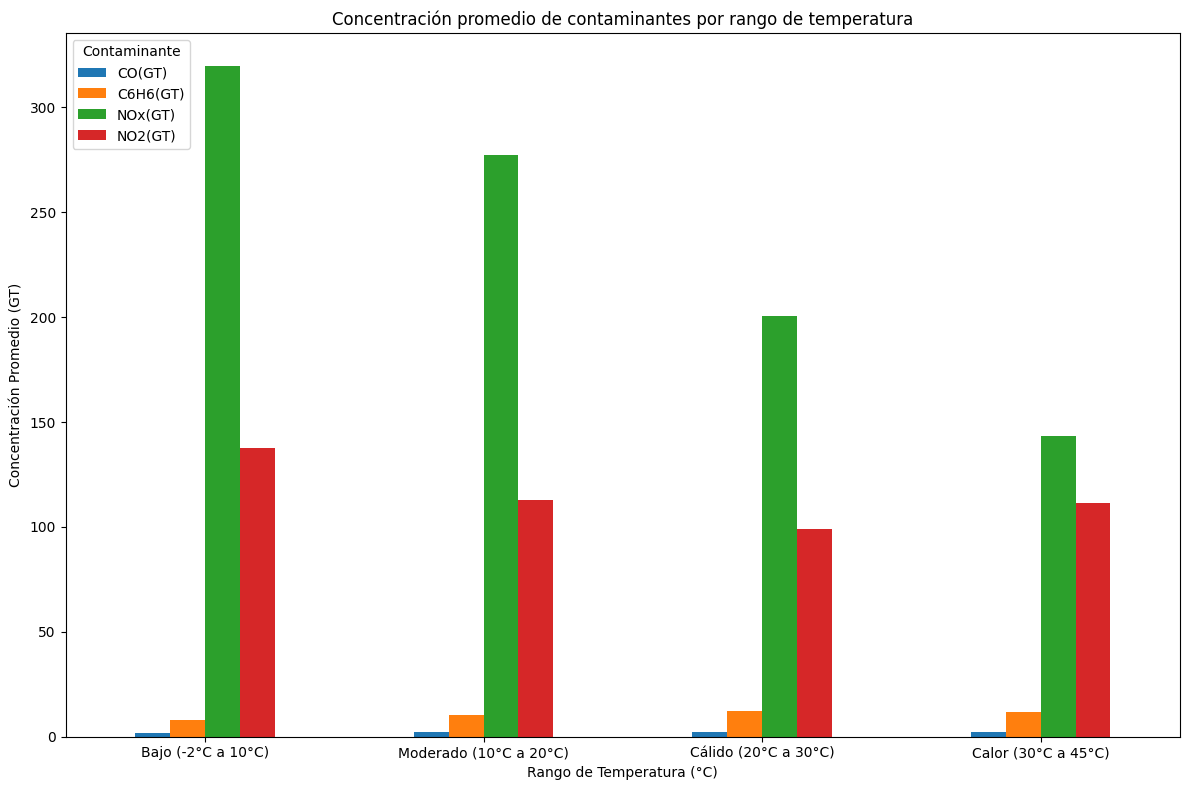

In [15]:
# Crear una nueva columna que clasifique la temperatura en rangos ajustados
bins = [-2, 10, 20, 30, 45]  # Rango ajustado para tu dataset
labels = ['Bajo (-2°C a 10°C)', 'Moderado (10°C a 20°C)', 'Cálido (20°C a 30°C)', 'Calor (30°C a 45°C)']
df['Temp_Rango'] = pd.cut(df['T'], bins=bins, labels=labels, right=False)

# Agrupar los datos por rango de temperatura y calcular la media de los gases
gases = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
df_temp_grouped = df.groupby('Temp_Rango')[gases].mean().reset_index()

# Crear un gráfico de barras comparando la concentración de los gases por rango de temperatura
fig, ax = plt.subplots(figsize=(12, 8))

df_temp_grouped.plot(kind='bar', x='Temp_Rango', y=gases, ax=ax, legend=True)

# Añadir títulos y etiquetas
ax.set_title('Concentración promedio de contaminantes por rango de temperatura')
ax.set_xlabel('Rango de Temperatura (°C)')
ax.set_ylabel('Concentración Promedio (GT)')
ax.set_xticklabels(df_temp_grouped['Temp_Rango'], rotation=0)
ax.legend(title='Contaminante', loc='upper left')

# Ajustar el diseño
plt.tight_layout()
plt.show()


# **Outliers**
Este código realiza un análisis de las columnas especificadas en un DataFrame para identificar y eliminar los valores atípicos (outliers).

### **Análisis de Mínimos y Máximos**  
Para cada columna indicada, el código calcula el valor mínimo, el valor máximo y el rango (diferencia entre el valor máximo y el mínimo). Esta información se imprime para tener una visión general de la distribución de los datos en esas columnas.

### **Detección de Outliers usando el Rango Intercuartílico (IQR)**  
Para cada columna, se calculan el primer cuartil (Q1) y el tercer cuartil (Q3), que representan los valores por debajo del cual se encuentra el 25% de los datos y por encima del cual se encuentra el 25%, respectivamente.  

- **IQR (Interquartile Range)**: Se obtiene restando Q1 de Q3, lo que indica la amplitud del rango en el que se encuentran la mayoría de los datos.  
- **Límites para los Outliers**: Los valores atípicos se definen como aquellos que están por debajo de Q1 - 3 * IQR o por encima de Q3 + 3 * IQR.  
- **Eliminación de Outliers**: Los valores que caen fuera de estos límites se eliminan del DataFrame, creando una nueva copia sin esos outliers.

### **Resultado**  
Al final, el DataFrame sin los outliers se almacena en la variable `df_outliers`, y se informa cuántos valores atípicos han sido eliminados de cada columna.

### **Conclusión**  
El valor **3** en la fórmula para la detección de outliers se elige por ser un umbral estándar en estadística. Este valor está basado en la convención de que en una distribución aproximadamente normal, el **99.7%** de los datos deberían caer dentro de 3 desviaciones estándar de la media. Al aplicar este umbral al rango intercuartílico, se cubren los datos más típicos y se eliminan los valores que se encuentran demasiado alejados, garantizando que el análisis no sea afectado por valores extremadamente inusuales.

In [16]:
# Columnas a analizar
columns_to_check = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'PT08.S1(CO)', 
                    'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

# Iterar sobre las columnas y calcular mínimos y máximos
for col in columns_to_check:
    min_value = df[col].min()
    max_value = df[col].max()
    print(f'\n{col}: Min = {min_value}, Max = {max_value}, Rango = {max_value - min_value}')


# Detectar y eliminar outliers usando IQR
df_outliers = df.copy()  # Copiar el DataFrame para no modificar el original
for col in columns_to_check:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Definir límites para valores atípicos
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR

    # Eliminar outliers
    df_outliers = df_outliers[(df_outliers[col] >= lower_bound) & (df_outliers[col] <= upper_bound)]

    print(f'{col} tiene {df.shape[0] - df_outliers.shape[0]} valores atípicos eliminados.')



CO(GT): Min = 0.1, Max = 11.9, Rango = 11.8

C6H6(GT): Min = 0.2, Max = 63.7, Rango = 63.5

NOx(GT): Min = 2.0, Max = 1479.0, Rango = 1477.0

NO2(GT): Min = 2.0, Max = 333.0, Rango = 331.0

PT08.S1(CO): Min = 647.0, Max = 2040.0, Rango = 1393.0

PT08.S2(NMHC): Min = 390.0, Max = 2214.0, Rango = 1824.0

PT08.S3(NOx): Min = 322.0, Max = 2683.0, Rango = 2361.0

PT08.S4(NO2): Min = 551.0, Max = 2775.0, Rango = 2224.0

PT08.S5(O3): Min = 221.0, Max = 2523.0, Rango = 2302.0

T: Min = -1.9, Max = 44.6, Rango = 46.5

RH: Min = 9.2, Max = 88.7, Rango = 79.5

AH: Min = 0.1847, Max = 2.1806, Rango = 1.9959
CO(GT) tiene 22 valores atípicos eliminados.
C6H6(GT) tiene 29 valores atípicos eliminados.
NOx(GT) tiene 61 valores atípicos eliminados.
NO2(GT) tiene 62 valores atípicos eliminados.
PT08.S1(CO) tiene 62 valores atípicos eliminados.
PT08.S2(NMHC) tiene 62 valores atípicos eliminados.
PT08.S3(NOx) tiene 86 valores atípicos eliminados.
PT08.S4(NO2) tiene 86 valores atípicos eliminados.
PT08.S5(

# Análisis de la Contaminación por Gases y Selección del Mejor Modelo de Clustering

El objetivo de este análisis es determinar cómo varían las concentraciones de los cuatro gases más perjudiciales para la salud, **'CO(GT)'**, **'C6H6(GT)'**, **'NOx(GT)'**, y **'NO2(GT)'**, a lo largo de los días de la semana. Además, se busca seleccionar el mejor modelo de clustering para cada uno de estos gases, con el fin de identificar patrones de contaminación en función de los días de la semana y los niveles de concentración de cada gas.

### Pasos Seguidos:

1. **Selección de Gases**: Se eligieron los siguientes gases debido a su impacto negativo en la salud humana y ambiental:
   - **'CO(GT)'**: Monóxido de carbono
   - **'C6H6(GT)'**: Benceno
   - **'NOx(GT)'**: Óxidos de nitrógeno
   - **'NO2(GT)'**: Dióxido de nitrógeno

2. **Análisis por Día de la Semana**: Para cada gas, se analizaron las concentraciones durante los diferentes días de la semana, con el fin de identificar patrones de contaminación en función de los días.

3. **Método del Codo**: Se aplicó el método del codo para determinar el número óptimo de clusters para cada gas. Este método ayuda a identificar el número ideal de clusters que mejor representa los datos, basándose en la inercia (el error cuadrático medio dentro de los clusters).

4. **Selección del Mejor Modelo de Clustering**: Se evaluaron varios modelos de clustering (como KMeans, DBSCAN, GMM, etc.) para cada gas. El objetivo fue seleccionar el modelo que mejor se ajuste a los datos y que sea capaz de identificar patrones significativos de contaminación a lo largo de los días de la semana.

5. **Evaluación de Modelos**: Para cada gas, se entrenaron los modelos de clustering con los datos correspondientes. Se utilizó el **Silhouette Score** como métrica para evaluar la calidad del clustering. Este score mide cómo de bien están separados los clusters, con valores cercanos a +1 indicando una buena separación.

### Resultado:

A partir del análisis realizado para los cuatro gases y los diferentes días de la semana, se seleccionó el mejor modelo de clustering para cada gas. Esto permitirá identificar de manera más precisa en qué días de la semana y qué periodos del día se presentan mayores niveles de contaminación, con el fin de implementar estrategias de control más efectivas para cada uno de los gases.

### Explicación del Método del Codo:

El **método del codo** es una técnica visual utilizada para seleccionar el número óptimo de clusters en un modelo de clustering como KMeans. Al entrenar el modelo para diferentes valores de K (el número de clusters), se calcula la inercia para cada K. La inercia mide la dispersión dentro de los clusters: un valor bajo indica que los puntos dentro de un cluster están cerca de su centro.

El gráfico resultante muestra cómo cambia la inercia a medida que se aumenta el número de clusters. El "codo" del gráfico es el punto en el que la disminución en la inercia comienza a estabilizarse, lo que indica que agregar más clusters ya no mejora significativamente el modelo. Este punto es considerado como el número óptimo de clusters.

Para cada gas, se realizó este análisis y se determinó que el número óptimo de clusters es **2**. Esto sugiere que los datos de concentración de estos gases pueden agruparse de manera efectiva en dos clusters, lo que ayuda a identificar patrones de contaminación en diferentes días de la semana.

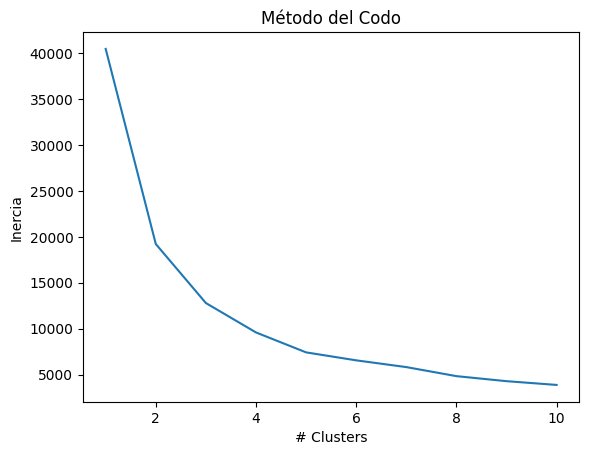

Número óptimo de clusters: 2


In [17]:
variable_X_CO = df_outliers[['CO(GT)','DiaSemana']]

# Función que calcula y dibuja el gráfico para utilizar el método del codo.
def elbow_method_kmeans(data, range_a, range_b):
    inercia = []
    for i in range(range_a, range_b):
        kmeans = KMeans(n_clusters=i, random_state=0)
        kmeans.fit(data)
        inercia.append(kmeans.inertia_)
    
    # Gráfico del codo
    plt.plot(range(range_a, range_b), inercia)
    plt.xlabel('# Clusters')
    plt.ylabel('Inercia')
    plt.title('Método del Codo')
    plt.show()

    # Cálculo del cambio en la inercia
    diffs = np.diff(inercia)
    optimal_k = np.argmin(diffs) + range_a + 1  # +1 porque np.diff reduce la longitud de la lista
    return optimal_k

# Determinar el número óptimo de clusters
optimal_clusters = elbow_method_kmeans(variable_X_CO, 1, 11)
print(f'Número óptimo de clusters: {optimal_clusters}')


### **1. Definición de Modelos de Clustering:**

El primer paso en el código es definir los modelos de clustering que se van a evaluar. Los modelos seleccionados son:

- **KMeans**: Utiliza el algoritmo de K-means para agrupar los datos en un número específico de clusters. Este es uno de los métodos más populares para el clustering.
- **MeanShift**: Un algoritmo de clustering basado en la densidad que no requiere que se especifique el número de clusters de antemano.
- **GMM (Gaussian Mixture Model)**: Un modelo probabilístico que asume que los datos provienen de una combinación de distribuciones gaussianas, lo que lo hace adecuado para clustering en casos no esféricos.
- **DBSCAN**: Un algoritmo de clustering basado en la densidad que puede identificar clusters de forma arbitraria y no requiere un número predefinido de clusters.
- **AgglomerativeClustering**: Un enfoque jerárquico para clustering, donde los clusters se construyen de abajo hacia arriba.

### **2. Definición de los Parámetros de Búsqueda:**

Se definen los **parámetros de búsqueda** para cada modelo. Estos son los valores que se probarán durante la búsqueda en cuadrícula (GridSearch) para encontrar los mejores hiperparámetros para cada modelo:

- Para **KMeans**, se especifican parámetros como el número de clusters, el método de inicialización de centroides (`k-means++` o `random`), el número máximo de iteraciones, entre otros.
- Para **MeanShift**, se definen parámetros como el **ancho de banda** (que controla la forma de los clusters), el número máximo de iteraciones y la cantidad de trabajos en paralelo.
- Para **GMM**, se ajustan parámetros como el número de componentes gaussianos, el tipo de covarianza, el número de inicializaciones y el método de inicialización.
- Para **DBSCAN**, se ajustan los parámetros de distancia mínima (`min_samples`) y el radio de vecindad (`eps`), que son esenciales para la formación de clusters basados en densidad.
- Para **AgglomerativeClustering**, se definen parámetros como el número de clusters, la métrica de distancia (euclidiana o manhattan) y el tipo de enlace (cómo se combinan los clusters).

### **3. Función de Evaluación de Modelos de Clustering:**

La función **`evaluar_modelo_clustering_con_pca`** es el núcleo del proceso de evaluación. Aquí se realiza lo siguiente:

1. **Pipeline**: Se utiliza un **Pipeline** para encadenar varios pasos de preprocesamiento y modelado. Los pasos en el pipeline son:
   - **Scaler**: Se aplica **MinMaxScaler** para normalizar los datos (esto es importante porque los modelos de clustering son sensibles a la escala de los datos).
   - **PCA**: **Principal Component Analysis** (PCA) se usa para reducir la dimensionalidad de los datos antes de aplicar el modelo de clustering. En este caso, se reduce a 2 componentes principales para facilitar la visualización posterior.
   - **Modelo**: Se ajusta el modelo de clustering con los parámetros seleccionados en la búsqueda en cuadrícula.

2. **GridSearchCV**: El uso de **GridSearchCV** permite probar diferentes combinaciones de los hiperparámetros definidos previamente. Este método realiza una **búsqueda exhaustiva** a través del espacio de parámetros especificado para cada modelo y selecciona los mejores valores. Además, **`cv=5`** indica que se está utilizando **validación cruzada de 5 pliegues** para evaluar la calidad del modelo en cada combinación de parámetros.

3. **Scoring con Silhouette Score**: El **Silhouette Score** se utiliza como métrica de evaluación. Esta métrica mide cuán similar es un punto a su propio cluster comparado con otros clusters. Los valores cercanos a +1 indican que los puntos están bien asignados a su cluster, mientras que los valores cercanos a -1 sugieren que los puntos están mal asignados.

### **4. Evaluación de Modelos:**

El bloque de código siguiente evalúa todos los modelos definidos utilizando la función de evaluación mencionada previamente. Para cada modelo, se realizan los siguientes pasos:

- **Entrenamiento del Modelo**: Se ajusta el modelo utilizando la mejor configuración de parámetros encontrados en el **GridSearchCV**.
- **Predicción de Etiquetas**: Una vez ajustado el modelo, se realiza la predicción de las etiquetas de clustering con el modelo entrenado.
- **Cálculo de Silhouette Score**: Se calcula el **Silhouette Score** para evaluar la calidad del clustering. Un valor alto indica que los clusters están bien separados.
- **Cálculo de V-Measure**: Se calcula el **V-Measure**, que es una medida de la calidad del clustering comparando las etiquetas predichas con las etiquetas reales. En este caso, se utiliza la variable **'CO(GT)'** como referencia para las etiquetas reales. Esta métrica es útil cuando se desea evaluar qué tan bien el clustering refleja la estructura verdadera de los datos.

### **5. Visualización de los Resultados:**

- **Visualización PCA**: Después de aplicar PCA, se visualiza el clustering proyectado en dos dimensiones para cada modelo de clustering. Esto ayuda a entender cómo se distribuyen los clusters en el espacio de características reducido.
- **Gráfico de Clustering**: Para cada modelo, se genera un gráfico de dispersión con los puntos coloreados según el cluster al que pertenecen. Esto permite ver visualmente cómo se han formado los clusters y evaluar la efectividad del modelo.

### **6. Resultados de la Evaluación:**

Finalmente, para cada modelo, se imprimen los resultados de la evaluación:

- **Silhouette Score**: Indica cuán bien se separan los clusters.
- **V-Measure**: Indica cuán bien las etiquetas predichas coinciden con la verdadera estructura de los datos.
- **Mejores Hiperparámetros**: Muestra los mejores parámetros seleccionados durante la búsqueda en cuadrícula.

### **Resumen y Comparación de Modelos:**

Con esta evaluación, puedes comparar los modelos de clustering en función de las siguientes métricas:

- **Silhouette Score**: Permite comparar qué tan bien separados están los clusters.
- **V-Measure**: Mide qué tan bien se ha logrado agrupar los datos en relación con las etiquetas reales.

Con estas métricas y visualizaciones, puedes seleccionar el modelo que mejor se adapte a los datos y comprender las diferencias en el rendimiento entre los distintos enfoques de clustering.

### **Conclusión:**

Este proceso te permite realizar una evaluación rigurosa de varios modelos de clustering utilizando parámetros optimizados, reducción de dimensionalidad con PCA, y métricas de evaluación como el **Silhouette Score** y el **V-Measure**. La implementación de **GridSearchCV** y **Pipeline** asegura que los modelos se entrenan y evalúan de manera eficiente, lo que permite tomar decisiones informadas sobre el modelo más adecuado para tu conjunto de datos.


Evaluando KMeans con PCA...
Fitting 5 folds for each of 192 candidates, totalling 960 fits

Evaluando MeanShift con PCA...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Evaluando GMM con PCA...
Fitting 5 folds for each of 256 candidates, totalling 1280 fits

Evaluando DBSCAN con PCA...
Fitting 5 folds for each of 192 candidates, totalling 960 fits

Evaluando AgglomerativeClustering con PCA...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Modelo: KMeans
Silhouette Score: 0.4630840262974555
V-Measure: 0.0071566846449005826
Mejores hiperparámetros seleccionados:
  algorithm: lloyd
  copy_x: True
  init: k-means++
  max_iter: 50
  n_clusters: 2
  n_init: 10
  random_state: 42
  tol: 0.0001
  verbose: 0


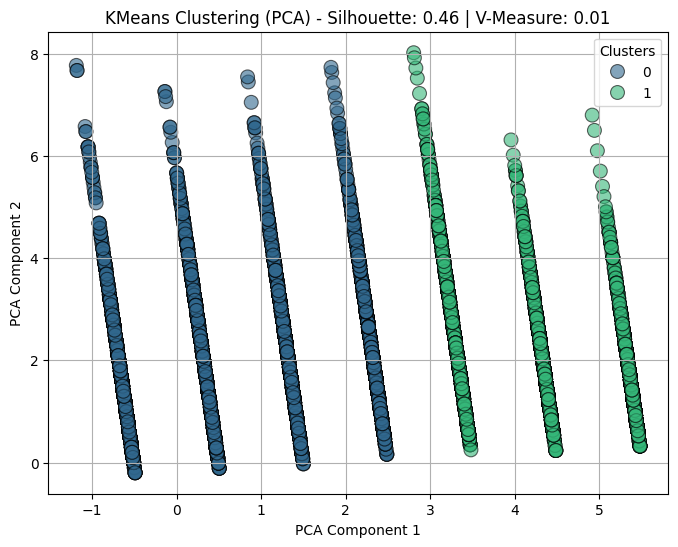


Modelo: MeanShift
Silhouette Score: 0.5027291434690975
V-Measure: 0.4230875918993725
Mejores hiperparámetros seleccionados:
  bandwidth: 0.5
  bin_seeding: True
  cluster_all: True
  max_iter: 300
  min_bin_freq: 1
  n_jobs: 1
  seeds: None


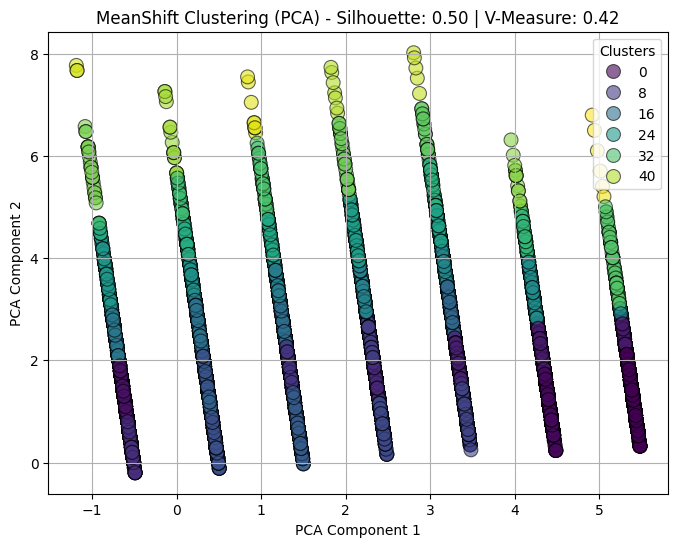


Modelo: GMM
Silhouette Score: 0.41817127313558305
V-Measure: 0.05144781571474489
Mejores hiperparámetros seleccionados:
  covariance_type: full
  init_params: kmeans
  max_iter: 100
  means_init: None
  n_components: 2
  n_init: 1
  precisions_init: None
  random_state: 42
  reg_covar: 1e-06
  tol: 0.001
  verbose: 0
  verbose_interval: 10
  warm_start: True
  weights_init: None


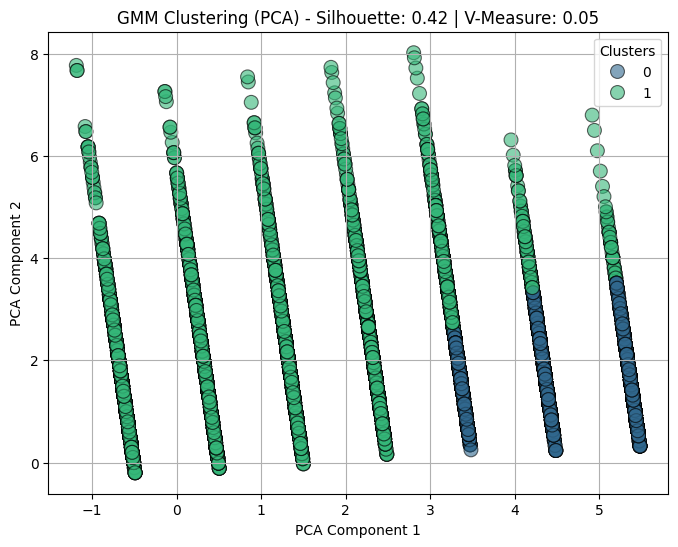


Modelo: DBSCAN
Silhouette Score: 0.23376632410725115
V-Measure: 0.03873266855925163
Mejores hiperparámetros seleccionados:
  algorithm: auto
  eps: 0.3
  leaf_size: 30
  metric: euclidean
  metric_params: None
  min_samples: 5
  n_jobs: -1
  p: 2


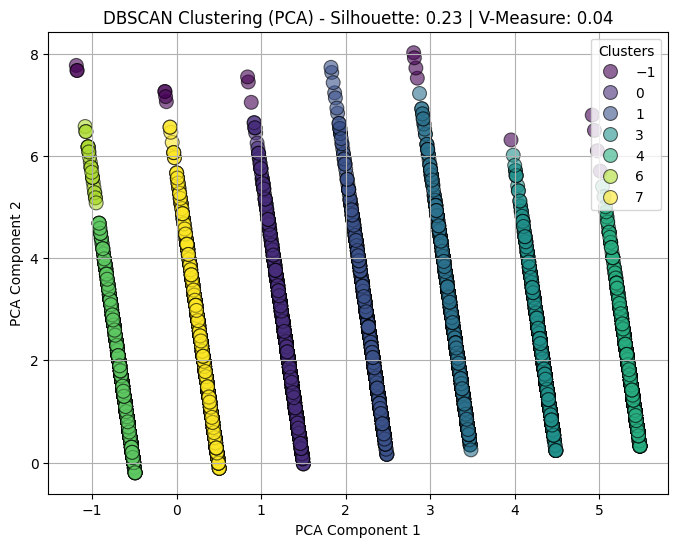


Modelo: AgglomerativeClustering
Silhouette Score: 0.4456652898610523
V-Measure: 0.02910233641837909
Mejores hiperparámetros seleccionados:
  compute_distances: False
  compute_full_tree: auto
  connectivity: None
  distance_threshold: None
  linkage: ward
  memory: None
  metric: euclidean
  n_clusters: 2


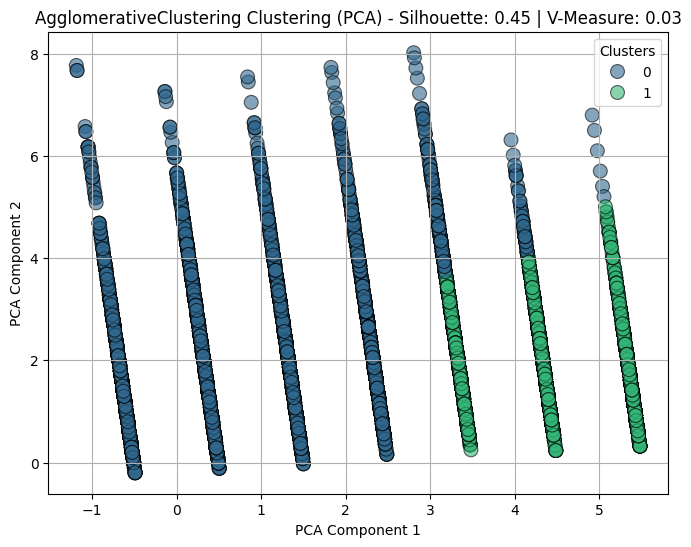

In [18]:
# Definir modelos de clustering
clustering_models = {
    'KMeans': KMeans(),
    'MeanShift': MeanShift(),
    'GMM': GaussianMixture(),
    'DBSCAN': DBSCAN(),
    'AgglomerativeClustering': AgglomerativeClustering()
}

# Definir parámetros de búsqueda
param_grids = {
    'KMeans': {
        'model__n_clusters': [optimal_clusters],                  
        'model__init': ['k-means++', 'random'],          
        'model__max_iter': [50, 200, 300],                        
        'model__tol': [1e-4, 1e-5],                           
        'model__algorithm': ['lloyd', 'elkan'],   
        'model__n_init': [10, 20],                           
        'model__random_state': [42, 100],                             
        'model__verbose': [0, 1],  
    },
    'MeanShift': {
        'model__bandwidth': [0.5, 1.0, 2.0],             
        'model__bin_seeding': [True, False],             
        'model__min_bin_freq': [1, 5],                      
        'model__max_iter': [300, 500],                  
        'model__n_jobs': [1, -1]
    },
    'GMM': { 
        'model__n_components': [optimal_clusters],                  
        'model__covariance_type': ['full', 'tied'],  
        'model__tol': [1e-3, 1e-4],                      
        'model__reg_covar': [1e-6, 1e-5],                
        'model__max_iter': [100, 200],                   
        'model__n_init': [1, 5],                           
        'model__init_params': ['kmeans', 'random'],            
        'model__random_state': [42, 100],
        'model__warm_start': [True, False]
    },
    'DBSCAN': {
        'model__eps': [0.3, 0.5, 1.0],
        'model__min_samples': [5, 10],
        'model__metric': ['euclidean', 'manhattan'],
        'model__algorithm': ['auto', 'ball_tree'],
        'model__leaf_size': [30, 50],
        'model__p': [2, 3],                                   
        'model__n_jobs': [-1, 1],                              
    },
    'AgglomerativeClustering': {
        'model__n_clusters':  [optimal_clusters],                      
        'model__metric': ['euclidean', 'manhattan'], 
        'model__linkage': ['ward', 'complete'],  
        'model__distance_threshold': [None, 5],           
    }
}

# Definir el scoring basado en Silhouette Score
silhouette_scorer = make_scorer(silhouette_score, metric='euclidean')

# Función para evaluar modelos de clustering con PCA
def evaluar_modelo_clustering_con_pca(model, param_grid, X, n_components=2):
    pipeline = Pipeline(steps=[ 
        ('scaler', MinMaxScaler()), 
        ('pca', PCA(n_components=n_components)), 
        ('model', model)            
    ])
    
    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring=silhouette_scorer,  
        cv=5,  
        verbose=2,
        n_jobs=-1
    )
    grid_search.fit(X)
    return grid_search.best_estimator_

# Preparar los datos
X = df_outliers[['CO(GT)', 'DiaSemana']]  # Seleccionar columnas relevantes

# Evaluar modelos con PCA
mejores_modelos = {}
for model_name, model in clustering_models.items():
    print(f"\nEvaluando {model_name} con PCA...")
    mejores_modelos[model_name] = evaluar_modelo_clustering_con_pca(
        model=model,
        param_grid=param_grids[model_name],
        X=X
    )

# Evaluar con Silhouette Score, V-Measure y visualizar resultados
for model_name, best_model in mejores_modelos.items():
    labels = best_model.named_steps['model'].fit_predict(X)
    silhouette = silhouette_score(X, labels)
    
    y_true = df_outliers['CO(GT)']  
    v_measure = v_measure_score(y_true, labels)

    # Extraer los hiperparámetros seleccionados
    best_params = best_model.named_steps['model'].get_params()
    
    print(f"\nModelo: {model_name}")
    print(f"Silhouette Score: {silhouette:}")
    print(f"V-Measure: {v_measure:}")
    print("Mejores hiperparámetros seleccionados:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")

    # Visualización del clustering con PCA
    X_pca = best_model.named_steps['pca'].transform(X)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette="viridis", s=100, alpha=0.6, edgecolor='k')
    plt.title(f"{model_name} Clustering (PCA) - Silhouette: {silhouette:.2f} | V-Measure: {v_measure:.2f}")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(title="Clusters", loc="upper right")
    plt.grid(True)
    plt.show()
